In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import io
import seaborn as sns
import glob
import polars as pl
import pandas as pd
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

cols_with_lists = [
        "nuc_starts",
        "nuc_lengths",
        "ref_nuc_starts",
        "ref_nuc_lengths",
        "msp_starts",
        "msp_lengths",
        "ref_msp_starts",
        "ref_msp_lengths",
        "m6a",
        "m6a_qual",
        "ref_m6a",
        "5mC",
        "ref_5mC",
    ]
    

def read_fibertools_rs_all_file(f: str, pandas=False, n_rows=None, long=False):
    """Read a table made with fibertools-rs. Specifically `ft extract --all`.
    Args:
        f (str): File path to the table. Can be compressed.
    Returns:
        pl.DataFrame: Dataframe of the table.
    """
    df = pl.read_csv(
        f,
        sep="\t",
        n_rows=n_rows,
        null_values=["."],
    )
    # clean up comment char
    df.columns = list(map(lambda x: x.strip("#"), df.columns))
    for col in cols_with_lists:
        df.replace(col, df[col].str.strip(",").str.split(",").cast(pl.List(pl.Int64)))
    if long:
        df = make_long(df)
    if pandas:
        return df.to_pandas()
    return df


def make_long(df):
    drop_cols = cols_with_lists
    for col in drop_cols:
        if col in df.columns and col not in ["m6a", "m6a_qual", "ref_m6a"]:
            df.drop_in_place(col)
    if "fiber_sequence" in df.columns:
        df.drop_in_place("fiber_sequence")
    return df.lazy().explode(["m6a", "m6a_qual", "ref_m6a"]).collect()


Red="#c1272d"
Indigo="#0000a7"
Yellow="#eecc16"
Teal="#008176"
Gray="#b3b3b3"
MODEL_COLORS = {"PacBio":Indigo, "CNN":Red, "XGB":Yellow, "GMM":Teal, "IPD":Gray}
MODEL_COLORS.update({"pb":Indigo, "cnn":Red, "xgb":Yellow, "gmm":Teal, "ipd":Gray, "semi":"orange"})


In [24]:
samples = ["PS00075_1", "PS00109_1"]
sm="PS00109_1"
sm="PS00075_1"

In [25]:
ipd_dfs = []
for sm in [sm]:
    for idx in [1,2,3]:
        #f=glob.glob(f"results/{sm}/ipdSummary/{sm}.{idx}-of-*.gff.gz")
        f=glob.glob(f"../results/{sm}/ipdSummary/{sm}.{idx}-of-*.gff.gz")
        print(f)
        f=f[0]
        t = pl.read_csv(f,sep=",").to_pandas()
        ipd_dfs.append(t)

ipd_df = pd.concat(ipd_dfs)
ipd_df = ipd_df[ipd_df.base == "A"]
ipd_df["fiber"] = ipd_df["refName"]
ipd_df["pos"] = ipd_df["tpl"]-1
ipd_df["ipd"] = ipd_df.score
ipd = ipd_df[["pos", "ipd", "fiber"]]
ipd.shape

['../results/PS00075_1/ipdSummary/PS00075_1.1-of-736.gff.gz']
['../results/PS00075_1/ipdSummary/PS00075_1.2-of-736.gff.gz']
['../results/PS00075_1/ipdSummary/PS00075_1.3-of-736.gff.gz']


(68442342, 3)

In [26]:
def load_ml_data(file, items_to_load = 10_000_000):
    ml_data = np.load(file, allow_pickle=True)
    fibers = ml_data["fibers"][0:items_to_load]
    positions = ml_data["positions"][0:items_to_load]
    labels = ml_data["labels"][0:items_to_load]
    ml_data = pd.DataFrame({"fiber": fibers, "pos": positions, "truth": labels})
    ml_data = ml_data[ml_data.fiber.isin(ipd.fiber.unique())]
    return ml_data

In [27]:
ml_data_1 = load_ml_data(f"../results/{sm}/ml/{sm}.npz")
ml_data = ml_data_1[ml_data_1.fiber.isin(ipd.fiber.unique())]
merge1 = ml_data.merge(ipd, how="left", on = ["pos", "fiber"])
ml_data.head()

,fiber,pos,truth
0,m54329U_210328_013807/19/ccs,4559,False
1,m54329U_210328_013807/19/ccs,2610,False
2,m54329U_210328_013807/19/ccs,788,False
3,m54329U_210328_013807/19/ccs,5759,False
4,m54329U_210328_013807/19/ccs,3481,False


In [28]:
def read_fiber_data(file, tag="xgb"):
    if False:
        df = pd.read_csv(file, sep="\t")
        df = df[["m6a", "m6a_qual", "fiber", "fiber_length", "strand"]]
        # filter 
        df = df[df.fiber.isin(ipd.fiber.unique())]
        df["m6a"] = df["m6a"].apply(lambda x: np.fromstring(x, sep=",", dtype=np.int32))
        df["m6a_qual"] = df["m6a_qual"].apply(lambda x: np.fromstring(x, sep=",", dtype=np.int32))
        df = df.explode(["m6a", "m6a_qual"])
    else: 
        df = read_fibertools_rs_all_file(file, long=True, pandas=True)
    # fix pos on the minus strand
    
    minus = df.strand == "-"
    df.loc[minus, "m6a"] = df[minus].fiber_length - df[minus].m6a - 1
    # switch to pos
    df["pos"] = df.m6a
    df[tag] = 255.0 * df.m6a_qual/df.m6a_qual.max()
    print(df.shape, tag)
    return df[[tag, "fiber", "pos"]]

In [29]:
if sm == "PS00075_1":
    pb = read_fiber_data("../from_pb/PS00075_1.fiberseq.strip_meth_tags.gamma_v4_cov1.bam.tbl.gz", "pb")
    merge_a = merge1.merge(pb, how="left", on = ["pos", "fiber"])
else: 
    merge_a = merge1
    merge_a["pb"] = 0

(106960864, 20) pb


In [ ]:
xgb = read_fiber_data(f"../data/{sm}.xgb.tbl.gz", tag="xgb")
merge2 = merge_a.merge(xgb, how="left", on = ["pos", "fiber"])

(83737663, 20) xgb


In [ ]:
cnn = read_fiber_data(f"../data/{sm}.cnn.tbl.gz", tag="cnn")
merge3 = merge2.merge(cnn, how="left", on = ["pos", "fiber"])

(44001254, 20) cnn


In [ ]:
merge3.to_csv(f"../tmp_{sm}_all_but_semi.csv.gz")
merge3 = pd.read_csv(f"../tmp_{sm}_all_but_semi.csv.gz")

In [ ]:
semi = read_fiber_data(f"../data/{sm}.semi.tbl.gz", tag="semi")
merge = merge3.merge(semi, how="left", on = ["pos", "fiber"])
print("done merging")

(45083478, 20) semi
done merging


In [ ]:
print(
    (merge.cnn>0).sum(),
    (merge.xgb>0).sum(),
    (merge.pb>0).sum(),
    (merge.semi>0).sum(),
)
print(
    merge.cnn.isna().sum(),
    merge.xgb.isna().sum(),
    merge.pb.isna().sum(),
    merge.semi.isna().sum(),
)
merge.replace(np.nan, 0, inplace=True)

454553 1028203 0 443739
1415224 841574 0 1426038


AUC-ROC ipd: 0.990
AUC-ROC xgb: 0.996
AUC-ROC cnn: 0.996


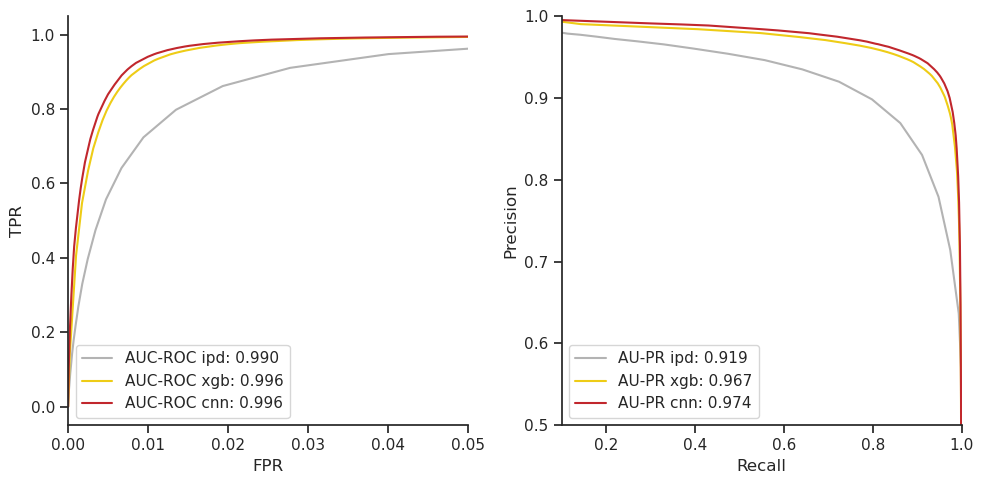

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1.axline([0,0], slope=1, c="black")

start = 0.5

tp, fp,ttt, p, r, tt, tags=[],[],[],[],[],[],[]
for tag in ["ipd", "pb",  "xgb", "cnn", "semi"]:
    color=MODEL_COLORS[tag]
    #if tag == "semi":
    #    continue
    if sm == "PS00109_1" and tag in ["pb", "semi"]:
        continue
    fpr, tpr, thresholds = metrics.roc_curve(merge.truth, merge[tag], pos_label=1)
    label = f"AUC-ROC {tag}: {metrics.auc(fpr, tpr):.03f}"
    print(label)
    #plt.text(.6, start, label , label=label, color=color) 
    ax1.plot(fpr, tpr, c=color, label=label)
    start -= 0.1
    
    precision, recall, t = metrics.precision_recall_curve(merge.truth, merge[tag], pos_label=1)
    label = f"AU-PR {tag}: {metrics.average_precision_score(merge.truth, merge[tag]):.03f}"
    
    ax2.plot(recall, precision, c=color, label=label)
    #ax2.scatter(recall, precision, c=color, label=label, s=5)
    z = pd.DataFrame({"p": precision[:t.shape[0]], "r": recall[:t.shape[0]], "t":t })
    #
    p += (precision).tolist()
    r += (recall).tolist()
    tp += (tpr).tolist()
    fp += (fpr).tolist()
    ttt += (thresholds).tolist() 
    if t.shape[0] < precision.shape[0]:
        tt += [t.min()] + t.tolist()
    else:
        tt += t.tolist()
    tags += precision.shape[0]*[tag]

ax1.legend()
ax2.legend()
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax1.set_xlim(0, 0.05)
ax2.set_xlim(.1,1)
ax2.set_ylim(0.5,1)

plt.tight_layout()
plt.savefig('../tmp.pdf')
plt.savefig(f"../Figures/{sm}-precision-recall.pdf")

     precision    recall  threshold  tag  difference
289    0.92929  0.927913      230.0  xgb    0.001377
     precision    recall  threshold  tag  difference
477   0.936112  0.935695      161.0  cnn    0.000417
Empty DataFrame
Columns: [precision, recall, threshold, tag, difference]
Index: []


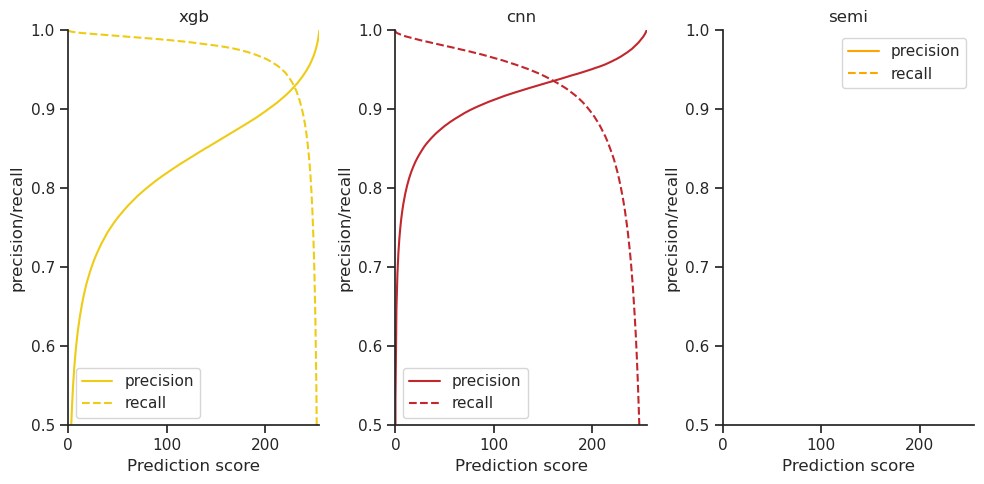

In [ ]:
pr_df = pd.DataFrame({"precision": p, "recall": r, "threshold": tt, "tag": tags})
tp_df = pd.DataFrame({"FPR": fp, "TPR": tp, "threshold": ttt})
pr_df["difference"]=(pr_df.precision - pr_df.recall).abs()

plt.rcParams['figure.figsize'] = [10, 5]

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
for tag, ax in zip(["xgb", "cnn", "semi"], [ax1,ax2,ax3]):
    color=MODEL_COLORS[tag]
    tdf = pr_df[pr_df.tag == tag]
    #tdf.diff
    ax.plot(tdf.threshold, tdf.precision, c=color, label=f"precision")
    ax.plot(tdf.threshold, tdf.recall, c=color, label=f"recall", linestyle="dashed")
    where = tdf.difference.min() == tdf.difference
    print(tdf[where])

    ax.legend()
    ax.set_xlabel("Prediction score")
    ax.set_ylabel("precision/recall")
    ax.set_xlim(0,255)
    ax.set_ylim(0.5,1)
    ax.set_title(tag)
    
plt.tight_layout()
plt.savefig('../tmp.pdf')
plt.savefig(f"../Figures/{sm}-precision-recall-threshold.pdf")

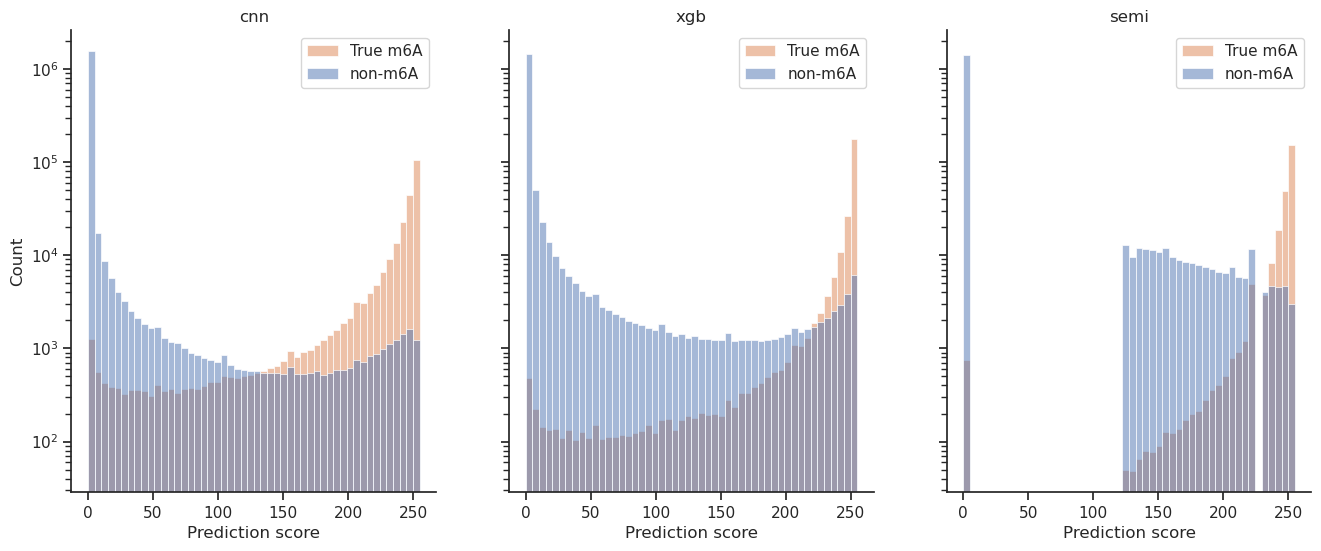

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,6))
for ax,tag in zip([ax1, ax2, ax3], ["cnn", "xgb", "semi"]):        
    g=sns.histplot(
        data=merge[(merge[tag] > -1)],
        x=tag, 
        bins=50,
        hue="truth",
        label="true",
        ax=ax
        #log_scale=True
        )
    g.set_yscale('log')
    g.set_xlabel("Prediction score")
    g.set(title=tag)
    legend = g.legend(["True m6A", "non-m6A"])
    #g.set_xlim(0,20)
plt.savefig('../tmp.pdf')
plt.savefig(f"../Figures/{sm}-quality-vs-m6A-status.pdf")

In [ ]:
def make_precision_score_table_from_npz(file):
    score_precision_table = np.load(file, allow_pickle=True)
    cnn_scores = score_precision_table['cnn_scores']
    precisions = score_precision_table['precision']
    df = pd.DataFrame({"cnn_score": cnn_scores, "precision": precisions}).drop_duplicates()
    # make closest u8 to the precision float
    df["precision_u8"] = (df.precision * 255.0).round().astype(np.uint8)
    # group by equal u8 precisions and get the minimum cnn score that achieves that precision
    t=df.groupby("precision_u8").aggregate({"cnn_score":"min", "precision":["min","max"]}).reset_index()
    print(t.head())
    print(t.tail())
    return t[["cnn_score", "precision_u8"]]

file = "./PS00075_3_precision_score_2.0.npz"
tbl = make_precision_score_table_from_npz(file)
tbl.to_json(f"{file}.json", index=False, orient="split")


file = "./PS00109_3_precision_score_2.2.npz"
tbl = make_precision_score_table_from_npz(file)
tbl.to_json(f"{file}.json", index=False, orient="split")
tbl

FileNotFoundError: [Errno 2] No such file or directory: './PS00075_3_precision_score_2.0.npz'

In [ ]:
251/255

0.984313725490196